In [107]:
##This is a framework of patch-based hyperspectral classification
import os
import time
import random
import spectral
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from sklearn.preprocessing import minmax_scale
from scipy.io import loadmat
from tqdm.notebook import tqdm
%matplotlib inline

In [108]:
##hypeperameters and experimental settings
RANDOM_SEED=666
MODEL_NAME = 'CNN1D' ## 
DATASET = 'PU'    ## PU  IP  SA  
TRAIN_RATE = 0.1  ## ratio of training data
VAL_RATE = 0.05    ## ratio of valuating data
EPOCH = 100    ##number of epoch
VAL_EPOCH = 1  ##interval of valuation
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 64
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components   0:use origin data
NORM = True  ## normalization or not
PATCH_SIZE = 1 ## patchsize of input 3D cube   1:only spectral sequence
SAVE_PATH = f"results\\{MODEL_NAME}\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [109]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [110]:
def loadData(name): ## customize data and return data label and class_name
    data_path = os.path.join(os.getcwd(),'dataset')
    if name == 'IP':
        data = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_gt.mat'))['indian_pines_gt']
        class_name = [ "Alfalfa", "Corn-notill", "Corn-mintill","Corn", "Grass-pasture", 
                       "Grass-trees","Grass-pasture-mowed", "Hay-windrowed", "Oats","Soybean-notill", "Soybean-mintill", "Soybean-clean","Wheat", "Woods", "Buildings-Grass-Trees-Drives","Stone-Steel-Towers"]
    elif name == 'SA':
        data = loadmat(os.path.join(data_path, 'Salinas\\Salinas_corrected.mat'))['salinas_corrected']
        labels = loadmat(os.path.join(data_path, 'Salinas\\Salinas_gt.mat'))['salinas_gt']
        class_name = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow',
                        'Fallow_rough_plow','Fallow_smooth','Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green','Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk','Vinyard_untrained','Vinyard_vertical']
    elif name == 'PU':
        data = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU.mat'))['paviaU']
        labels = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU_gt.mat'))['paviaU_gt']
        class_name = ['Asphalt', 'Meadows', 'Gravel', 'Trees','Painted metal sheets', 'Bare Soil', 
                      'Bitumen','Self-Blocking Bricks', 'Shadows']
    return data, labels, class_name


In [111]:
data,label,class_name = loadData(DATASET)
NUM_CLASS = label.max()

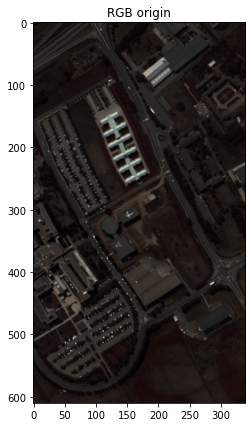

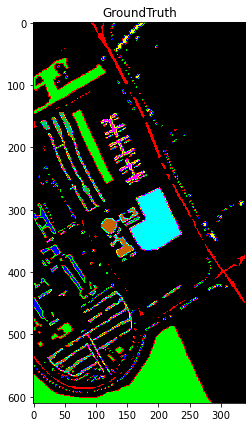

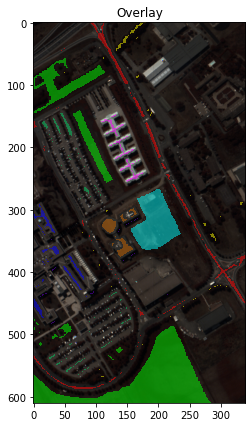

In [112]:
## display HSI
rgb_view=spectral.imshow(data,(30,20,10),classes=label,title='RGB origin',figsize=(7,7))
gt_view = spectral.imshow(classes=label, title='GroundTruth',figsize=(7,7))
view = spectral.imshow(data,(30,20,10),classes=label,figsize=(7,7))
view.set_display_mode('overlay')
view.class_alpha = 0.5
view.set_title('Overlay')
spectral.save_rgb(f'results/{DATASET}_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'results/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

In [113]:
## show 3D cube
# %matplotlib auto
# spectral.view_cube(data,(30,20,10))   ## depends on wxpython and pyopengl

In [114]:
def applyPCA(X, numComponents=15, norm = True):
    """PCA and processing
    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional):  number of reserved components(Defaults to 15, 0 for no PCA).
        norm: normalization or not
    Returns:
        newX: processed data
        pca: 
    """
    if numComponents == 0:
        newX = X
    else:
        newX = np.reshape(X, (-1, X.shape[2]))
        pca = PCA(n_components=numComponents)   ##PCA and normalization
        newX = pca.fit_transform(newX)
    if norm:
        newX = minmax_scale(newX, axis=1)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, newX.shape[2]

In [115]:
data,N_PCA = applyPCA(data, N_PCA, NORM)
data.shape,N_PCA

((610, 340, 15), 15)

In [116]:
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    if train_rate > 1:
       train_rate = int(train_rate)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt

In [117]:
train_gt, test_gt = sample_gt(label,TRAIN_RATE)
val_gt,test_gt = sample_gt(test_gt,VAL_RATE/(1-TRAIN_RATE))

          class          train_num  val_num   test_num   total   
         Asphalt            663       332       5636      6631   
         Meadows            1865      932      15852     18649   
         Gravel             210       105       1784      2099   
          Trees             306       153       2605      3064   
  Painted metal sheets      134        67       1144      1345   
        Bare Soil           503       251       4275      5029   
         Bitumen            133        67       1130      1330   
  Self-Blocking Bricks      368       184       3130      3682   
         Shadows             95        47       805       947    
          total             4277      2138     36361     42776   


ImageView object:
  Interpolation       :  <default>

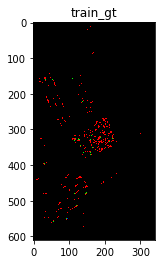

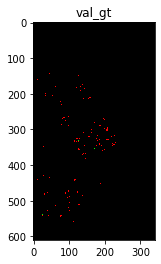

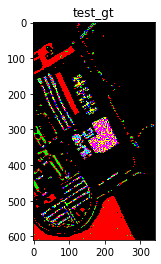

In [118]:
## display sampling info
sample_report = f"{'class': ^25}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{class_name[i-1]: ^25}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^25}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
print(sample_report)
spectral.imshow(classes=train_gt, title='train_gt')
spectral.imshow(classes=val_gt, title='val_gt')
spectral.imshow(classes=test_gt, title='test_gt')

In [119]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 
        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label


In [120]:
##create dataset and dataloader
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
all_data = PatchSet(data, label, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

In [121]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([15, 1, 1]), tensor(2))

In [122]:
## establish model
## write you model here and use follow frame

# # class MODEL(nn.Module):

# #     def __init__(self, input_channels, n_classes, *args):
# #         super(MODEL, self).__init__()
        
# #     def forward(self, x):
# #         return x

## we use CNN1D as example
import math
from torch.nn import init
class MODEL(nn.Module):
    """
    Deep Convolutional Neural Networks for Hyperspectral Image Classification
    Wei Hu, Yangyu Huang, Li Wei, Fan Zhang and Hengchao Li
    Journal of Sensors, Volume 2015 (2015)
    https://www.hindawi.com/journals/js/2015/258619/
    """
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
            init.uniform_(m.weight, -0.05, 0.05)
            init.zeros_(m.bias)

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, self.input_channels)
            x = self.pool(self.conv(x))
        return x.numel() 

    def __init__(self, input_channels, n_classes, kernel_size=None, pool_size=None):
        super(MODEL, self).__init__()
        if kernel_size is None:
           kernel_size = math.ceil(input_channels / 9)
        if pool_size is None:
           pool_size = math.ceil(kernel_size / 5)
        self.input_channels = input_channels

        self.conv = nn.Conv1d(1, 20, kernel_size)
        self.pool = nn.MaxPool1d(pool_size)
        self.features_size = self._get_final_flattened_size()
        self.fc1 = nn.Linear(self.features_size, 100)
        self.fc2 = nn.Linear(100, n_classes)
        self.apply(self.weight_init)

    def forward(self, x):
        x = x.squeeze(dim=-1).squeeze(dim=-1)
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = torch.tanh(self.pool(x))
        x = x.view(-1, self.features_size)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

##display network details
net = MODEL(N_PCA,n_classes=NUM_CLASS)
summary(net, input_size=(1,N_PCA,PATCH_SIZE,PATCH_SIZE),col_names=['num_params','kernel_size','mult_adds','input_size','output_size'],col_width=10,row_settings=['var_names'],depth=4)

Layer (type (var_name))                  Param #    Kernel Shape Mult-Adds  Input Shape Output Shape
MODEL                                    --         --         --         --         --
├─Conv1d (conv)                          60         [1, 20, 2] 840        [1, 1, 15] [1, 20, 14]
├─MaxPool1d (pool)                       --         --         --         [1, 20, 14] [1, 20, 14]
├─Linear (fc1)                           28,100     [280, 100] 28,100     [1, 280]   [1, 100]
├─Linear (fc2)                           909        [100, 9]   909        [1, 100]   [1, 9]
Total params: 29,069
Trainable params: 29,069
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.12

In [123]:
## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []
model = MODEL(N_PCA,n_classes=NUM_CLASS) ##modify to you model 

model.to(device)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()

train_st = time.time()
try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        model.train()
        avg_loss = 0.
        train_acc = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            val_acc =0
            model.eval()
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            torch.save(model.state_dict(),save_name)
except Exception as exc:
    print(exc)
finally: 
    print(f'Stop in epoch {e}')
train_time = time.time()-train_st
print(f"training time: {train_time}")

Training::   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

epoch 0/100 loss:0.028739951524830377  acc:0.4339490296937105


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 0/100  val_acc:0.43592142188961647


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 1/100 loss:0.021904161426824248  acc:0.5265372924947394


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 1/100  val_acc:0.5851262862488307


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 2/100 loss:0.01599492709269333  acc:0.6317512274959084


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 2/100  val_acc:0.676800748362956


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 3/100 loss:0.013193144108721216  acc:0.6855272387187281


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 3/100  val_acc:0.6898971000935453


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 4/100 loss:0.011717148353375088  acc:0.7049333645078326


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 4/100  val_acc:0.7146866230121609


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 5/100 loss:0.01068023884717287  acc:0.7264437689969605


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 5/100  val_acc:0.7521047708138447


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 6/100 loss:0.010106448093697042  acc:0.745616086041618


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 6/100  val_acc:0.7329279700654817


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 7/100 loss:0.009672013543213476  acc:0.7591769932195465


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 7/100  val_acc:0.7633302151543498


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 8/100 loss:0.009320877591722447  acc:0.7654898293196165


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 8/100  val_acc:0.7661365762394762


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 9/100 loss:0.00904838203241091  acc:0.7715688566752397


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 9/100  val_acc:0.7670720299345183


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 10/100 loss:0.008784422667917872  acc:0.7750759878419453


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 10/100  val_acc:0.7703461178671656


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 11/100 loss:0.0086078641220652  acc:0.7776478840308627


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 11/100  val_acc:0.7764265668849392


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 12/100 loss:0.008437712462338048  acc:0.784428337619827


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 12/100  val_acc:0.775023386342376


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 13/100 loss:0.008195795347012173  acc:0.7916764086976853


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 13/100  val_acc:0.7862488306828812


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 14/100 loss:0.008076455901375379  acc:0.7919102174421323


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 14/100  val_acc:0.7839101964452759


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 15/100 loss:0.007896599491985429  acc:0.7968202010755202


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 15/100  val_acc:0.8016838166510758


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 16/100 loss:0.007760813575162212  acc:0.7991582885199906


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 16/100  val_acc:0.7960710944808232


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 17/100 loss:0.007629710901332621  acc:0.7991582885199906


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 17/100  val_acc:0.80355472404116


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 18/100 loss:0.007445841769846572  acc:0.8050035071311668


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 18/100  val_acc:0.7951356407857811


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 19/100 loss:0.007304777427619379  acc:0.8094458732756605


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 19/100  val_acc:0.803086997193639


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 20/100 loss:0.007237664060891441  acc:0.8092120645312134


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 20/100  val_acc:0.8096351730589336


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 21/100 loss:0.007038216112037393  acc:0.8136544306757073


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 21/100  val_acc:0.8152478952291862


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 22/100 loss:0.006898007107611597  acc:0.8204348842646715


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 22/100  val_acc:0.8199251637043966


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 23/100 loss:0.006782684923751292  acc:0.8192658405424363


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 23/100  val_acc:0.8227315247895229


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 24/100 loss:0.006656180838153884  acc:0.8281505728314239


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 24/100  val_acc:0.8325537885874649


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 25/100 loss:0.006476798774846558  acc:0.8314238952536824


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 25/100  val_acc:0.8442469597754911


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 26/100 loss:0.006374067072280802  acc:0.8337619826981529


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 26/100  val_acc:0.8442469597754911


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 27/100 loss:0.006279267919434268  acc:0.8421790974982465


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 27/100  val_acc:0.8484565014031805


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 28/100 loss:0.006130280497059076  acc:0.8449848024316109


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 28/100  val_acc:0.8610851262862488


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 29/100 loss:0.006113228520305741  acc:0.8459200374093991


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 29/100  val_acc:0.8554724041159962


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 30/100 loss:0.005925247919094013  acc:0.8484919335983165


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 30/100  val_acc:0.8517305893358279


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 31/100 loss:0.005809184924196578  acc:0.8524666822539163


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 31/100  val_acc:0.8587464920486436


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 32/100 loss:0.005693283232539955  acc:0.8608837970540099


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 32/100  val_acc:0.8559401309635173


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 33/100 loss:0.005596799698003073  acc:0.8653261631985036


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 33/100  val_acc:0.853601496725912


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 34/100 loss:0.005523732110164643  acc:0.862052840776245


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 34/100  val_acc:0.8573433115060805


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 35/100 loss:0.005425996905959653  acc:0.867664250642974


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 35/100  val_acc:0.8615528531337698


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 36/100 loss:0.005369632833467234  acc:0.8664952069207388


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 36/100  val_acc:0.8643592142188962


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 37/100 loss:0.005267351921512781  acc:0.8723404255319149


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 37/100  val_acc:0.8564078578110383


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 38/100 loss:0.0052532796787831005  acc:0.8718728080430208


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 38/100  val_acc:0.8596819457436857


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 39/100 loss:0.005123083073596183  acc:0.8770166004208557


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 39/100  val_acc:0.8737137511693172


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 40/100 loss:0.005056477976871033  acc:0.8798223053542202


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 40/100  val_acc:0.8695042095416277


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 41/100 loss:0.0050395348339903594  acc:0.878653261631985


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 41/100  val_acc:0.8793264733395697


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 42/100 loss:0.004892692443698485  acc:0.8809913490764555


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 42/100  val_acc:0.8690364826941066


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 43/100 loss:0.00487887656051811  acc:0.8793546878653261


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 43/100  val_acc:0.8793264733395697


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 44/100 loss:0.004811806268493567  acc:0.8833294365209259


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 44/100  val_acc:0.8868101028999065


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 45/100 loss:0.00473428925733185  acc:0.8877718026654197


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 45/100  val_acc:0.8769878391019644


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 46/100 loss:0.004718063774163516  acc:0.8922141688099134


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 46/100  val_acc:0.883068288119738


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 47/100 loss:0.004680167506489209  acc:0.8859013327098434


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 47/100  val_acc:0.882600561272217


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 48/100 loss:0.004598350635833598  acc:0.889642272620996


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 48/100  val_acc:0.8807296538821329


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 49/100 loss:0.004519000234853616  acc:0.8905775075987842


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 49/100  val_acc:0.8811973807296539


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 50/100 loss:0.004492065872102523  acc:0.8919803600654664


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 50/100  val_acc:0.8900841908325537


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 51/100 loss:0.004468584572123344  acc:0.8924479775543606


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 51/100  val_acc:0.8905519176800748


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 52/100 loss:0.004423521767438559  acc:0.8936170212765957


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 52/100  val_acc:0.882600561272217


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 53/100 loss:0.004394102656091517  acc:0.8910451250876783


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 53/100  val_acc:0.8910196445275959


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 54/100 loss:0.004344358522883079  acc:0.8964227262099602


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 54/100  val_acc:0.892422825070159


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 55/100 loss:0.004347858116508004  acc:0.8912789338321253


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 55/100  val_acc:0.891955098222638


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 56/100 loss:0.004226019703982337  acc:0.8980593874210896


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 56/100  val_acc:0.8900841908325537


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 57/100 loss:0.004179434907862815  acc:0.8994622398877719


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 57/100  val_acc:0.8938260056127222


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 58/100 loss:0.004137424301370885  acc:0.8996960486322189


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 58/100  val_acc:0.8989710009354537


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 59/100 loss:0.004125256735029303  acc:0.906242693476736


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 59/100  val_acc:0.8835360149672591


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 60/100 loss:0.004087029474832924  acc:0.90039747486556


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 60/100  val_acc:0.8975678203928905


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 61/100 loss:0.003999033384939653  acc:0.9048398410100538


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 61/100  val_acc:0.9003741814780168


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 62/100 loss:0.004010195002701897  acc:0.9076455459434183


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 62/100  val_acc:0.8905519176800748


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 63/100 loss:0.003965132036010099  acc:0.9043722235211596


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 63/100  val_acc:0.8985032740879326


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 64/100 loss:0.003940251889088345  acc:0.906242693476736


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 64/100  val_acc:0.9022450888681011


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 65/100 loss:0.0039267233558310955  acc:0.9036707972878185


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 65/100  val_acc:0.8961646398503275


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 66/100 loss:0.0038720222173908867  acc:0.9092822071545476


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 66/100  val_acc:0.8956969130028064


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 67/100 loss:0.003768635807902506  acc:0.9118541033434651


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 67/100  val_acc:0.9027128157156221


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 68/100 loss:0.0038160364121122008  acc:0.9090483984101005


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 68/100  val_acc:0.9059869036482694


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 69/100 loss:0.003759298047674909  acc:0.9104512508767828


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 69/100  val_acc:0.9031805425631432


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 70/100 loss:0.0036797566247482516  acc:0.9146598082768296


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 70/100  val_acc:0.9064546304957904


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 71/100 loss:0.0037374691530340934  acc:0.9109188683656769


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 71/100  val_acc:0.8961646398503275


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 72/100 loss:0.0036916836559674937  acc:0.9099836333878887


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 72/100  val_acc:0.9106641721234799


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 73/100 loss:0.0036398898849343483  acc:0.9155950432546177


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 73/100  val_acc:0.9045837231057062


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 74/100 loss:0.0036395537186399195  acc:0.9151274257657236


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 74/100  val_acc:0.9045837231057062


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 75/100 loss:0.0036053930435165056  acc:0.9155950432546177


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 75/100  val_acc:0.9059869036482694


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 76/100 loss:0.0035429232193539013  acc:0.9148936170212766


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 76/100  val_acc:0.9078578110383536


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 77/100 loss:0.003518449398215363  acc:0.9176993219546411


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 77/100  val_acc:0.9144059869036483


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 78/100 loss:0.0035332610548894374  acc:0.9148936170212766


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 78/100  val_acc:0.9134705332086062


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 79/100 loss:0.0034668786881932707  acc:0.9169978957213


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 79/100  val_acc:0.9064546304957904


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 80/100 loss:0.003498765394554981  acc:0.9174655132101941


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 80/100  val_acc:0.9153414405986904


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 81/100 loss:0.0034200071936626984  acc:0.9176993219546411


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 81/100  val_acc:0.9139382600561272


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 82/100 loss:0.0033304647189561303  acc:0.9205050268880056


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 82/100  val_acc:0.9158091674462114


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 83/100 loss:0.003431898679149633  acc:0.9153612345101707


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 83/100  val_acc:0.912067352666043


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 84/100 loss:0.0033151889592234933  acc:0.9233107318213701


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 84/100  val_acc:0.9148737137511693


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 85/100 loss:0.003328269344499966  acc:0.9200374093991115


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 85/100  val_acc:0.9115996258185219


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 86/100 loss:0.0032499289475006843  acc:0.9214402618657938


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 86/100  val_acc:0.8999064546304958


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 87/100 loss:0.0033077347569859194  acc:0.9193359831657704


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 87/100  val_acc:0.9111318989710009


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 88/100 loss:0.0032054711867499247  acc:0.9237783493102643


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 88/100  val_acc:0.9153414405986904


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 89/100 loss:0.00330141737015414  acc:0.9198036006546645


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 89/100  val_acc:0.912067352666043


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 90/100 loss:0.003175513128588237  acc:0.9247135842880524


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 90/100  val_acc:0.9106641721234799


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 91/100 loss:0.0032555636541988908  acc:0.9200374093991115


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 91/100  val_acc:0.9115996258185219


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 92/100 loss:0.003166556086583703  acc:0.9240121580547113


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 92/100  val_acc:0.9144059869036483


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 93/100 loss:0.0031525246312971117  acc:0.9235445405658171


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 93/100  val_acc:0.912067352666043


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 94/100 loss:0.003184344526314975  acc:0.9207388356324526


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 94/100  val_acc:0.9148737137511693


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 95/100 loss:0.003156675505309231  acc:0.9219078793546879


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 95/100  val_acc:0.9027128157156221


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 96/100 loss:0.003210096795313097  acc:0.922609305588029


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 96/100  val_acc:0.9106641721234799


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 97/100 loss:0.003030834976049793  acc:0.9275192892214169


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 97/100  val_acc:0.912535079513564


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 98/100 loss:0.003098915839950587  acc:0.928688332943652


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 98/100  val_acc:0.9111318989710009


  0%|          | 0/67 [00:00<?, ?it/s]

epoch 99/100 loss:0.0030683578123326108  acc:0.9265840542436287


  0%|          | 0/34 [00:00<?, ?it/s]

epoch 99/100  val_acc:0.9148737137511693
Stop in epoch 99
training time: 25.600484609603882


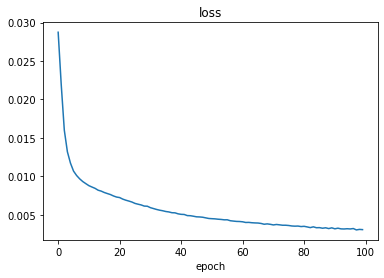

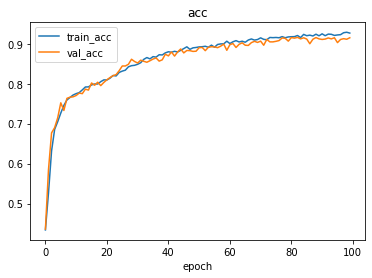

In [124]:
##display loss and acc
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax2 = fig2.add_subplot(1,1,1)
ax1.plot(np.arange(e+1),loss_list)
ax1.set_title('loss')
ax1.set_xlabel('epoch')
ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
ax2.set_title('acc')
ax2.set_xlabel('epoch')
ax2.legend()

In [125]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    """get best model path by valuation list
    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir
    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

best model:epoch_82_acc_0.9158.pth


  0%|          | 0/3241 [00:00<?, ?it/s]

inferring time: 3.7580230236053467


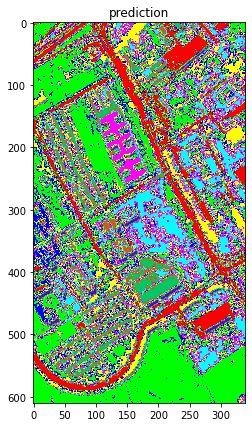

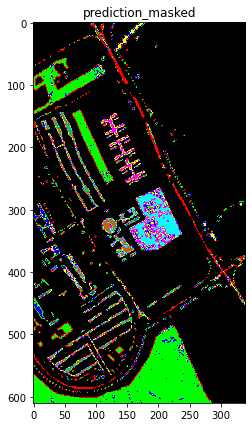

In [126]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH)

best_model = MODEL(N_PCA,n_classes=NUM_CLASS)  ## modify to you model

best_model.load_state_dict(torch.load(best_model_path))
## inference
best_model.to(device)
best_model.eval()
pred_map = []
infer_st = time.time() 
for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
    data = data.to(device)
    target = best_model(data)
    _, pred = torch.max(target, dim = 1)
    pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
infer_time = time.time() - infer_st
print(f"inferring time: {infer_time}")
pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(label.shape[0],label.shape[1])
spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
spectral.imshow(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction_masked.jpg"),pred_map*(label!=0),colors = spectral.spy_colors)

In [127]:
## classfication report
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += f"training time: {train_time}\ninferring time: {infer_time}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'classfication_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 0.9098209620197464
AA: 0.8874343898446985
Kappa: 0.8800653084501947
training time: 25.600484609603882
inferring time: 3.7580230236053467
                      precision    recall  f1-score   support

             Asphalt     0.9492    0.8845    0.9157      5636
             Meadows     0.9416    0.9635    0.9524     15852
              Gravel     0.7986    0.7046    0.7487      1784
               Trees     0.9090    0.8472    0.8770      2605
Painted metal sheets     0.9845    0.9965    0.9904      1144
           Bare Soil     0.8928    0.8613    0.8768      4275
             Bitumen     0.7737    0.8442    0.8074      1130
Self-Blocking Bricks     0.7810    0.8888    0.8314      3130
             Shadows     0.9913    0.9963    0.9938       805

            accuracy                         0.9098     36361
           macro avg     0.8913    0.8874    0.8882     36361
        weighted avg     0.9111    0.9098    0.9096     36361

